# Pre-Processing and Modeling

In [1]:
# pip install tensorflow

In [2]:
import os
import requests
import random
import pandas as pd
import datetime
from datetime import date
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import warnings
warnings.filterwarnings('ignore')

2024-02-26 12:53:10.300024: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Read in prepared data

merged = pd.read_csv('./data/merged.csv')

# We only need numeric columns for modeling
drop_cols = ['date', 'day_of_week', 'axis_label', 'error_count', 'anomaly_type']
merged_vars_only = merged[[col for col in merged.columns if col not in drop_cols]].reset_index(drop=True)


In [4]:
# The last element contains the labels
labels = merged_vars_only.iloc[:, -1]

# The other data points are the metadata variables themselves
data = merged_vars_only.iloc[:, 0:-1]


train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.25, random_state=42
)

In [5]:
train_data = tf.convert_to_tensor(train_data)
test_data = tf.convert_to_tensor(test_data)

min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [6]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

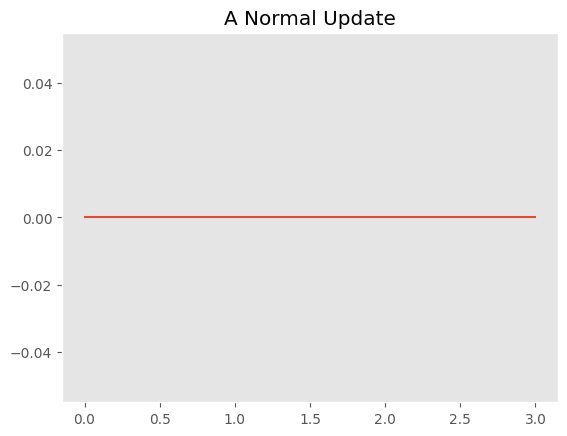

In [7]:
plt.grid()
plt.plot(np.arange(4), normal_train_data[0])
plt.title("A Normal Update")
plt.show()

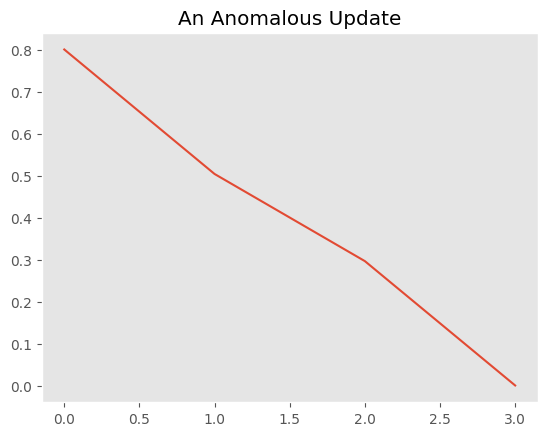

In [8]:
plt.grid()
plt.plot(np.arange(4), anomalous_train_data[0])
plt.title("An Anomalous Update")
plt.show()

In [9]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"), 
            layers.Dense(16, activation="relu"), 
            layers.Dense(8, activation="relu")])

        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"), 
            layers.Dense(32, activation="relu"),
            layers.Dense(4, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

In [10]:
autoencoder.compile(optimizer='adam', loss='mae', metrics=["accuracy"])

In [11]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=100, 
          batch_size=100,            
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/100
4/4 [==============================] - 2s 92ms/step - loss: 0.3888 - accuracy: 0.4433 - val_loss: 0.2934 - val_accuracy: 0.0960
Epoch 2/100
4/4 [==============================] - 0s 27ms/step - loss: 0.3843 - accuracy: 0.8522 - val_loss: 0.2887 - val_accuracy: 0.9996
Epoch 3/100
4/4 [==============================] - 0s 26ms/step - loss: 0.3804 - accuracy: 0.9974 - val_loss: 0.2847 - val_accuracy: 0.9996
Epoch 4/100
4/4 [==============================] - 0s 26ms/step - loss: 0.3767 - accuracy: 0.9974 - val_loss: 0.2811 - val_accuracy: 0.9996
Epoch 5/100
4/4 [==============================] - 0s 32ms/step - loss: 0.3727 - accuracy: 0.9974 - val_loss: 0.2771 - val_accuracy: 0.9996
Epoch 6/100
4/4 [==============================] - 0s 32ms/step - loss: 0.3681 - accuracy: 0.9974 - val_loss: 0.2725 - val_accuracy: 0.9996
Epoch 7/100
4/4 [==============================] - 0s 27ms/step - loss: 0.3630 - accuracy: 0.9974 - val_loss: 0.2671 - val_accuracy: 0.9996
Epoch 8/100
4/4 [===

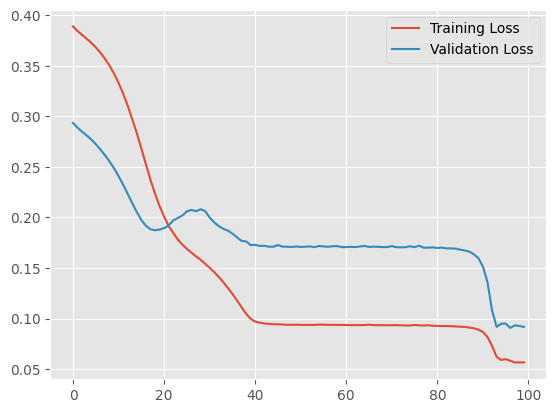

In [12]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

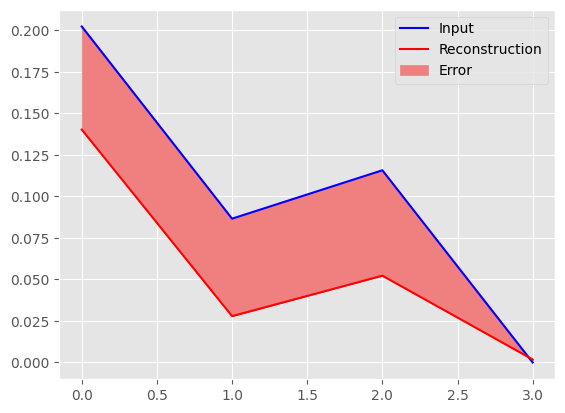

In [13]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(4), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

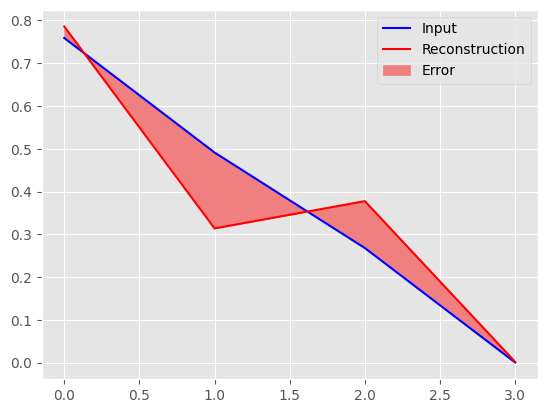

In [14]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(4), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

12/12 [==============================] - 0s 3ms/step


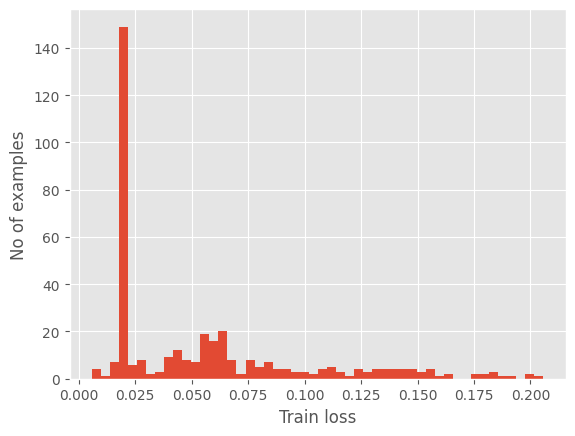

In [15]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [16]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", float(threshold))

Threshold:  0.10221747308969498


79/79 [==============================] - 0s 2ms/step


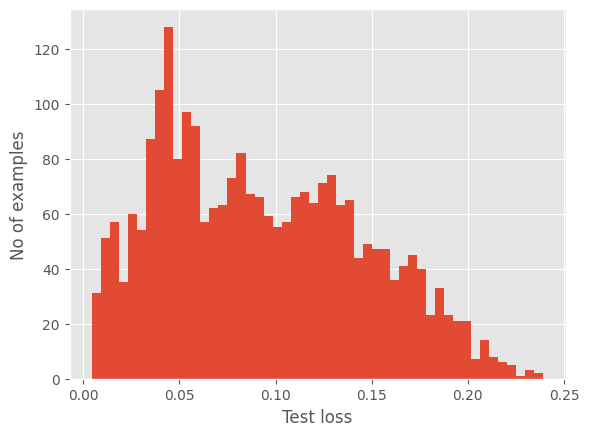

In [17]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [18]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

In [19]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.44076190476190474
Precision = 0.06233766233766234
Recall = 0.8


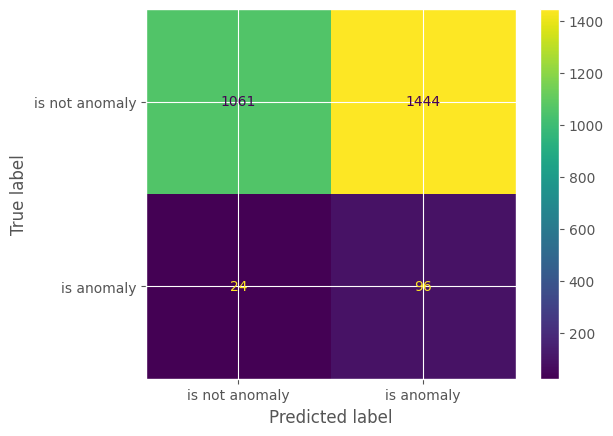

In [20]:
ConfusionMatrixDisplay.from_predictions(test_labels, preds, labels=[0,1], display_labels=['is not anomaly', 'is anomaly'])

## Results  

While the recall rate of this model is relatively good, the overall accuracy is low. Further optimization is needed in order to get this model working as a reliable tool for detecting unexpected dataset updates.  

Recommended Next Steps

- Implement tracking of model performace – optimization steps should be logged and results recorded so that relevant adjustments can be made towards improving model accuracy. This can be in the form of a pandas df or a csv file
- Implement ROC visualizations to optimize the true positives vs true negatives
- Experiment with different topographies of the autoencoder
- Test what happens when more or fewer epochs & batches are used
- What happens when you use the mean-sampled dataset?
- Are there other points of metadata that can be collected on dataset updates?